In [123]:
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [78]:
AA=pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
print("total countries wit non-null values: "+str(AA.loc[AA['total_tests'].isnull()==False,'iso_code'].nunique()))
AA.loc[AA['total_tests'].isnull()==False,'iso_code'].unique()

total countries wit non-null values: 72


array(['ARG', 'AUS', 'AUT', 'BEL', 'BGD', 'BHR', 'BOL', 'CAN', 'CHE',
       'CHL', 'COL', 'CRI', 'CUB', 'CZE', 'DEU', 'DNK', 'ECU', 'ESP',
       'EST', 'ETH', 'FIN', 'FRA', 'GBR', 'GHA', 'GRC', 'HKG', 'HUN',
       'IDN', 'IND', 'IRL', 'IRN', 'ISL', 'ISR', 'ITA', 'JPN', 'KEN',
       'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'MYS', 'NGA', 'NLD', 'NOR',
       'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'ROU', 'RUS', 'SEN', 'SGP', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE',
       'THA', 'TUN', 'TUR', 'TWN', 'UGA', 'URY', 'USA', 'VNM', 'ZAF'],
      dtype=object)

In [42]:
DF_TEST=pd.read_csv("full-list-total-tests-for-covid-19.csv")

In [248]:
CONFIRMED_CASES=pd.read_csv("confirmed_cases_JH.csv",index_col=0)
DEATHS=pd.read_csv("deaths_JH.csv",index_col=0)
codes_iso=pd.read_csv("ISO3_COUNTRYREG.csv",index_col=0)
DF_TEST=pd.read_csv("full-list-total-tests-for-covid-19.csv")

In [249]:
def reshape_data(dataset,var_name):
    ## reshape of the JH dataset
    CC=dataset
    var_calendario=CC.columns[4:]
    var_ids=CC.columns[0:4]
    CC=pd.melt(CC,var_ids,var_calendario,var_name='time',value_name=var_name)
    CC=CC.groupby(['Country/Region','time'],as_index=False)[var_name].sum()
    return CC


list_dataset=[CONFIRMED_CASES,DEATHS]
list_var_name=['confirmed_cases','deaths_cases']
DF=pd.DataFrame()

i=0
for dt,vn in zip(list_dataset,list_var_name):
    if i==0:
        DF=DF.append(reshape_data(dataset=dt,var_name=vn))
    else:
        DF=pd.merge(DF,reshape_data(dataset=dt,var_name=vn),on=['time','Country/Region'],how='left')
    i+=1


In [250]:
DF=pd.merge(DF,codes_iso[['ISO3',"Country/Region"]].drop_duplicates(),on='Country/Region',how='left')

In [251]:
## format time variable

DF_TEST['time']=pd.to_datetime(DF_TEST['Date'])
DF['time']=pd.to_datetime(DF['time'])

## change names
DF_TEST.rename({'Code':'ISO3'},inplace=True,axis=1)
DF_TEST.rename({'Total tests':'tests'},inplace=True,axis=1)

## merge
DF_ANALYSIS=pd.merge(DF,DF_TEST,on=['time','ISO3'],how='left')

## ratio variables
DF_ANALYSIS['death_rate']=DF_ANALYSIS['deaths_cases']/DF_ANALYSIS['confirmed_cases']
DF_ANALYSIS['positivity_rate']=DF_ANALYSIS['confirmed_cases']/DF_ANALYSIS['tests']

### drop null values and countries with less than 100 deaths
DF_PLT=DF_ANALYSIS.loc[DF_ANALYSIS['deaths_cases']>=100,:]
DF_PLOT=DF_PLT.dropna().copy()

## take last observation in time order
DFZ=DF_PLOT.sort_values('time',ascending=False).groupby(['ISO3'],as_index=False)['death_rate','positivity_rate','time','confirmed_cases','tests'].first()

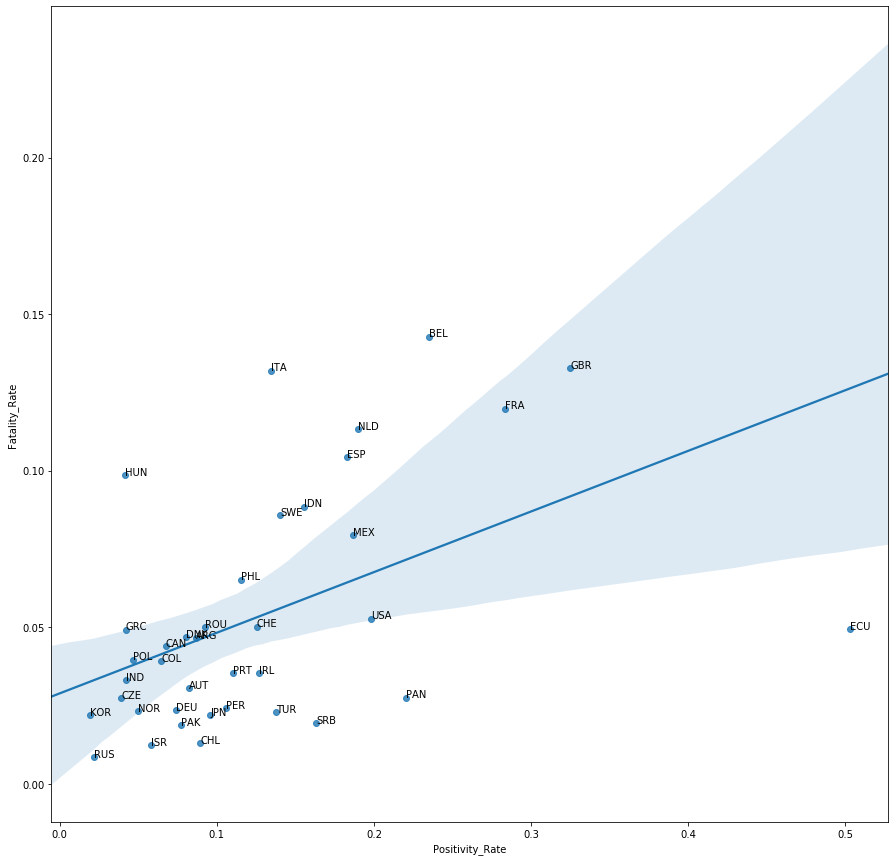

In [252]:
## rename label
DFZ.rename({'positivity_rate':"Positivity_Rate","death_rate":"Fatality_Rate"},axis=1,inplace=True)

fig,axs=plt.subplots(figsize=(15,15))
sns.regplot(x='Positivity_Rate',y='Fatality_Rate',data=DFZ,ax=axs)

for label,posy,posx in zip(DFZ['ISO3'],DFZ["Fatality_Rate"],DFZ['Positivity_Rate']):
    axs.text(posx,posy,label)

we decide to drop ecuador

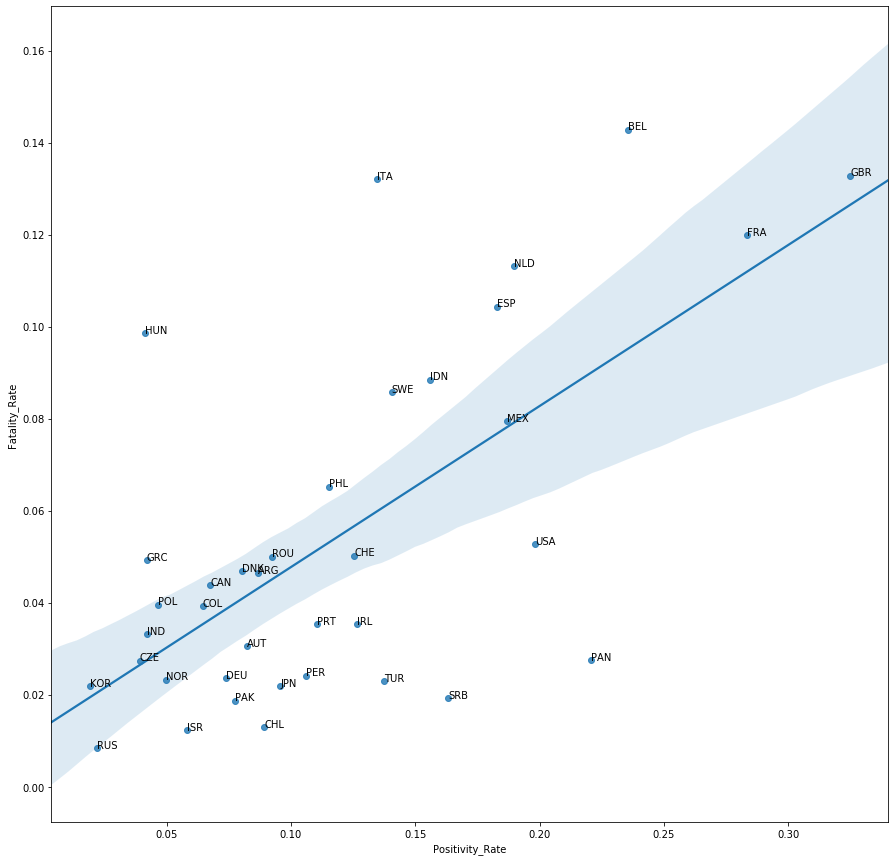

In [253]:
DFZ=DFZ.loc[DFZ['ISO3']!="ECU",:].copy()

fig,axs=plt.subplots(figsize=(15,15))
sns.regplot(x='Positivity_Rate',y='Fatality_Rate',data=DFZ,ax=axs)

for label,posy,posx in zip(DFZ['ISO3'],DFZ["Fatality_Rate"],DFZ['Positivity_Rate']):


residuals differences

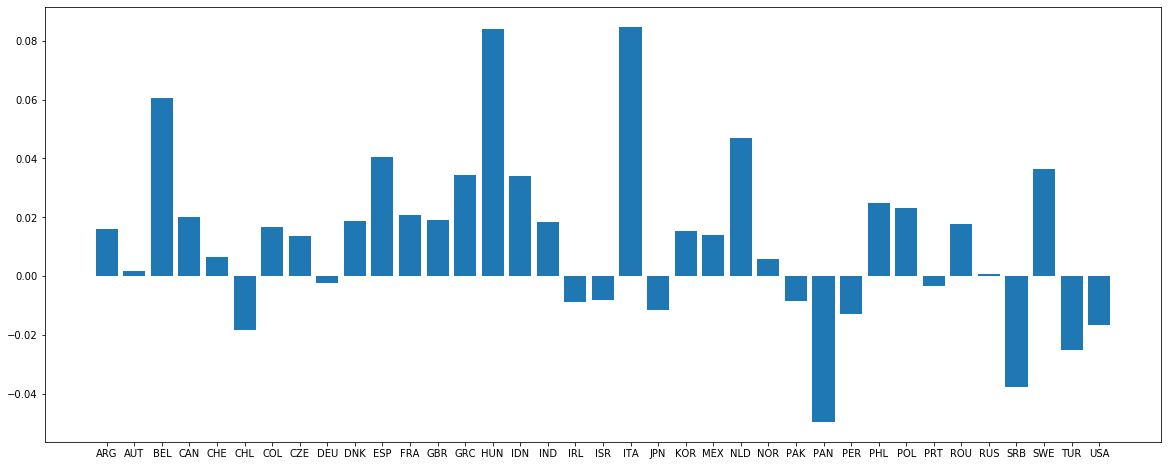

In [257]:
fig,axs=plt.subplots(figsize=(20,8))
DFZ['actual_death_rate']=results.resid+results.params[0]
plt.bar(height=DFZ['actual_death_rate'],x=DFZ['ISO3']);
#plt.bar(height=DFZ['share_65_plus'],x=DFZ['ISO3'])

### applying the same framework for italy

In [125]:
DB_reg=pd.read_excel("dati_per_la_voce_casitestati.xlsx")

In [127]:
DD=DB_reg.copy()
DD['fatality_rate']=DD['deceduti']/DD['totale_casi']
DD['positivity_rate']=DD['totale_casi']/DD['casi_testati']
DD.sort_values('fatality_rate',ascending=False).round(3);

In [128]:
results=smf.ols('positivity_rate  ~ + fatality_rate ',data=DD).fit(cov_type='HC2')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     41.97
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           3.30e-06
Time:                        23:44:00   Log-Likelihood:                 29.936
No. Observations:                  21   AIC:                            -55.87
Df Residuals:                      19   BIC:                            -53.78
Df Model:                           1                                         
Covariance Type:                  HC2                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0648      0.042     -1.548      0.122      -0.147       0.017
fatality_rate     2.3542      0.363      6.479      0.000       1.642       3.066
==============================================================================
Omnibus:                       10.653   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                8.251
Skew:                           1.290   Prob(JB):                       0.0162
Kurtosis:                       4.666   Cond. No.                         30.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

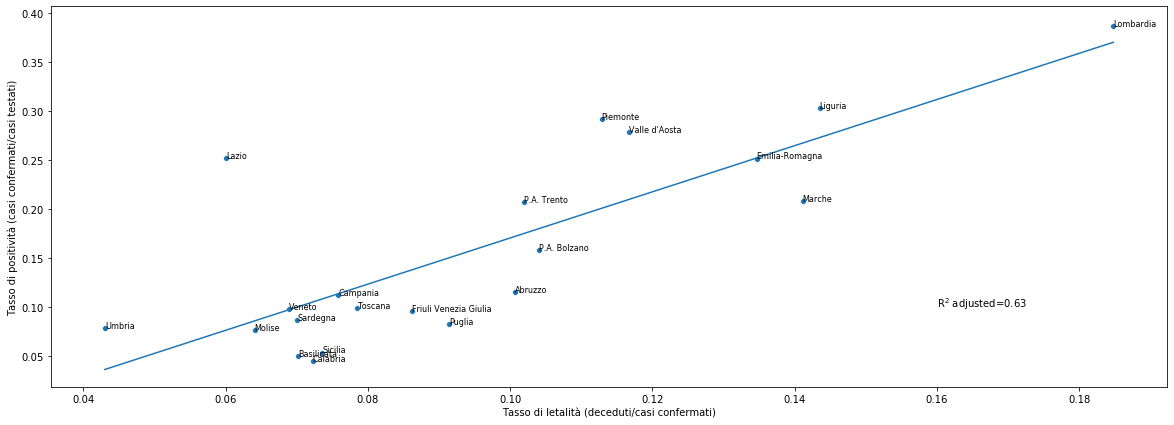

In [138]:
fig,axs=plt.subplots(figsize=(20,7))
#DD=DB_reg.groupby('denominazione_regione',as_index=False)['totale_casi','tamponi','deceduti','ricoverati_con_sintomi','totale_ospedalizzati'].last()

sns.lineplot(y=results.predict(),x=DD['fatality_rate'],ax=axs)
sns.scatterplot(DD['fatality_rate'],DD['positivity_rate'],ax=axs);

for x,y,label in zip(DD['fatality_rate'],DD['positivity_rate'],DD['denominazione_regione']):
    axs.text(x,y,label,fontsize=8)

axs.text(0.16,0.10,"R$^{2}$ adjusted="+str(np.round(results.rsquared_adj,2)))
axs.set_ylabel("Tasso di positività (casi confermati/casi testati)")
axs.set_xlabel("Tasso di letalità (deceduti/casi confermati)");